**LSTM MODEL COMPARISON IN 2020 PREDICTION WITH 2 PREVIOUS YEARS PREDICTIONS**

The LSTM model using the same hyperparameters obtained from best hyperparameters in the previous testing. 2010-2017 data are used as training set. 2018, 2019, and 2020 data are used as testing set seperately. The results from these 3 testing set will be compared to see the model's performance 

In [ ]:
#!pip install tensorflow-gpu
#!pip uninstall tf-nightly
#!pip install tf-nightly

In [ ]:
#import library

from google.colab import files
import tensorflow as tf  
import pandas as pd
import numpy as np
from numpy import array
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM
from sklearn.metrics import mean_squared_error
import random as python_random
import datetime

In [ ]:
#mount drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Daily timeframe**

In [ ]:
#read data to pandas dataframe

path = "drive/My Drive/Colab Notebooks/EURUSDdaily.csv"
dataDaily = pd.read_csv(path, names=['date','time','open','high','low','close','volume'])
dataDaily.tail(10)

,date,time,open,high,low,close,volume
12483,2020.10.07,00:00,1.17335,1.17818,1.17248,1.17628,46612
12484,2020.10.08,00:00,1.17624,1.17816,1.17324,1.17582,39212
12485,2020.10.09,00:00,1.17587,1.18304,1.17551,1.18293,40290
12486,2020.10.12,00:00,1.18173,1.18265,1.17866,1.18120,34400
12487,2020.10.13,00:00,1.18120,1.18155,1.17305,1.17446,40707
12488,2020.10.14,00:00,1.17452,1.17712,1.17195,1.17452,41998
12489,2020.10.15,00:00,1.17452,1.17576,1.16882,1.17073,46911
12490,2020.10.16,00:00,1.17073,1.17460,1.16939,1.17153,41413
12491,2020.10.19,00:00,1.17181,1.17929,1.17023,1.17656,50490
12492,2020.10.20,00:00,1.17660,1.17700,1.17652,1.17694,331


Data Preparation

In [ ]:
#get the required data

dataDaily = dataDaily.loc[(dataDaily['date']<='2020.10.20') & (dataDaily['date']>='2010.05.04')]

In [ ]:
#make data to time-series data with one time-step afterward

dataDaily['shift_close'] = dataDaily['close'].shift(-1)

In [ ]:
#drop unnecessary data

dataDaily.drop(dataDaily.loc[dataDaily['date']=='2020.10.20'].index, inplace=True)

In [ ]:
#reset index

dataDaily.reset_index(inplace=True)
dataDaily

,index,date,time,open,high,low,close,volume,shift_close
0,9774,2010.05.04,00:00,1.31884,1.32131,1.29629,1.29718,48690,1.28182
1,9775,2010.05.05,00:00,1.29702,1.29956,1.27891,1.28182,57402,1.26296
2,9776,2010.05.06,00:00,1.28191,1.28557,1.25270,1.26296,73442,1.27518
3,9777,2010.05.07,00:00,1.26296,1.27973,1.25860,1.27518,83142,1.27864
4,9778,2010.05.10,00:00,1.29299,1.30934,1.27588,1.27864,78501,1.26328
...,...,...,...,...,...,...,...,...,...
2713,12487,2020.10.13,00:00,1.18120,1.18155,1.17305,1.17446,40707,1.17452
2714,12488,2020.10.14,00:00,1.17452,1.17712,1.17195,1.17452,41998,1.17073
2715,12489,2020.10.15,00:00,1.17452,1.17576,1.16882,1.17073,46911,1.17153
2716,12490,2020.10.16,00:00,1.17073,1.17460,1.16939,1.17153,41413,1.17656


Data Preprocessing

In [ ]:
#convert data to numpy array

arrD_close = dataDaily['close'].to_numpy()
arrD_date = dataDaily['date'].to_numpy()

arrD_shiftclose = dataDaily['shift_close'].to_numpy()

In [ ]:
#normalize data using min-max scaler

scaler = MinMaxScaler()
scaled_close_daily = scaler.fit_transform(arrD_close.reshape(-1,1))
scaled_shiftclose_daily = scaler.fit_transform(arrD_shiftclose.reshape(-1,1))

#print(scaled_dataX)
#print(scaled_dataY)

In [ ]:
#split train and test data

trainDaily_x = scaled_close_daily[0:1992,:]
test1Daily_x = scaled_close_daily[1992:2251,:]
test2Daily_x = scaled_close_daily[2251:2510,:]
test3Daily_x = scaled_close_daily[2510:,:]

trainDaily_y = scaled_shiftclose_daily[0:1992,:]
test1Daily_y = scaled_shiftclose_daily[1992:2251,:]
test2Daily_y = scaled_shiftclose_daily[2251:2510,:]
test3Daily_y = scaled_shiftclose_daily[2510:,:]

#split train and test date data
trainDaily_date = arrD_date[0:1992]
test1Daily_date = arrD_date[1992:2251]
test2Daily_date = arrD_date[2251:2510]
test3Daily_date = arrD_date[2510:]


print(trainDaily_date[len(trainDaily_date)-1])
print(test1Daily_date[len(test1Daily_date)-1])
print(test2Daily_date[len(test2Daily_date)-1])
print(test3Daily_date[len(test3Daily_date)-1])


2017.12.29
2018.12.31
2019.12.31
2020.10.19


In [ ]:
#reshape input to be [samples, time steps, features]

trainDailyX = np.reshape(trainDaily_x, (trainDaily_x.shape[0], trainDaily_x.shape[1], 1))
test1DailyX = np.reshape(test1Daily_x, (test1Daily_x.shape[0], test1Daily_x.shape[1], 1))
test2DailyX = np.reshape(test2Daily_x, (test2Daily_x.shape[0], test2Daily_x.shape[1], 1))
test3DailyX = np.reshape(test3Daily_x, (test3Daily_x.shape[0], test3Daily_x.shape[1], 1))

#print(trainX)
#print(testX)

Training

In [ ]:
#to not get random result

# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.
np.random.seed(123)

# The below is necessary for starting core Python generated random numbers
# in a well-defined state.
python_random.seed(123)

# The below set_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see:
# https://www.tensorflow.org/api_docs/python/tf/random/set_seed
tf.random.set_seed(1234)

In [ ]:
#Create LSTM

t_steps = 1
n_feature = 1
model = Sequential()
#model.add(LSTM(10, input_shape=(t_steps, n_feature), return_sequences=True))
model.add(LSTM(10, input_shape=(t_steps, n_feature), return_sequences=True))
model.add(LSTM(10, input_shape=(t_steps, n_feature), return_sequences=False))
model.add(Dropout(0.1))
model.add(Dense(1)) #output layer
model.compile(loss='mean_squared_error', optimizer='adam')

#earlyStop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30)
#mCheckpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 10)             480       
_________________________________________________________________
lstm_1 (LSTM)                (None, 10)                840       
_________________________________________________________________
dropout (Dropout)            (None, 10)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 11        
Total params: 1,331
Trainable params: 1,331
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#train model

history = model.fit(trainDailyX, trainDaily_y, epochs=192, verbose=1, validation_split=0.33, shuffle=False)

Epoch 1/192
42/42 [==============================] - 1s 22ms/step - loss: 0.3573 - val_loss: 0.0143
Epoch 2/192
42/42 [==============================] - 0s 4ms/step - loss: 0.2436 - val_loss: 0.0081
Epoch 3/192
42/42 [==============================] - 0s 4ms/step - loss: 0.1182 - val_loss: 0.0446
Epoch 4/192
42/42 [==============================] - 0s 4ms/step - loss: 0.0377 - val_loss: 0.1015
Epoch 5/192
42/42 [==============================] - 0s 4ms/step - loss: 0.0227 - val_loss: 0.1040
Epoch 6/192
42/42 [==============================] - 0s 4ms/step - loss: 0.0207 - val_loss: 0.0976
Epoch 7/192
42/42 [==============================] - 0s 4ms/step - loss: 0.0206 - val_loss: 0.0937
Epoch 8/192
42/42 [==============================] - 0s 4ms/step - loss: 0.0190 - val_loss: 0.0871
Epoch 9/192
42/42 [==============================] - 0s 4ms/step - loss: 0.0175 - val_loss: 0.0821
Epoch 10/192
42/42 [==============================] - 0s 3ms/step - loss: 0.0175 - val_loss: 0.0776
Epoch 11

Testing

In [ ]:
#test model

#predict 1
test1Daily_predict = model.predict(test1DailyX, verbose=1)
#print(test_predict)

#predict 2
test2Daily_predict = model.predict(test2DailyX, verbose=1)
#print(test_predict)

#predict 3
test3Daily_predict = model.predict(test3DailyX, verbose=1)
#print(test_predict)

7/7 [==============================] - 0s 2ms/step


In [ ]:
#invert value

trainY_daily = scaler.inverse_transform(trainDaily_y)
predictedTest1_daily = scaler.inverse_transform(test1Daily_predict)
test1Y_daily = scaler.inverse_transform(test1Daily_y)

predictedTest2_daily = scaler.inverse_transform(test2Daily_predict)
test2Y_daily = scaler.inverse_transform(test2Daily_y)

predictedTest3_daily = scaler.inverse_transform(test3Daily_predict)
test3Y_daily = scaler.inverse_transform(test3Daily_y)


In [ ]:
#reshape array to 1d array

trainY_daily = trainY_daily.flatten()

predictedTest1_daily = predictedTest1_daily.flatten()
test1Y_daily = test1Y_daily.flatten()

predictedTest2_daily = predictedTest2_daily.flatten()
test2Y_daily = test2Y_daily.flatten()

predictedTest3_daily = predictedTest3_daily.flatten()
test3Y_daily = test3Y_daily.flatten()


**1-hour timeframe**

In [ ]:
#read data to pandas dataframe

path = "drive/My Drive/Colab Notebooks/EURUSD1hour.csv"
data1hour = pd.read_csv(path, names=['date','time','open','high','low','close','volume'])
data1hour.head(10)

,date,time,open,high,low,close,volume
0,date,time,open,high,low,close,volume
1,2010.05.04,00:00,1.31884,1.31981,1.31853,1.3198,750
2,2010.05.04,01:00,1.31982,1.32004,1.31885,1.31942,626
3,2010.05.04,02:00,1.31947,1.3212,1.31915,1.32083,954
4,2010.05.04,03:00,1.32084,1.32131,1.3197,1.32073,896
5,2010.05.04,04:00,1.32076,1.32122,1.31928,1.32013,893
6,2010.05.04,05:00,1.32012,1.32039,1.31943,1.32018,647
7,2010.05.04,06:00,1.3202,1.3209,1.31949,1.32069,845
8,2010.05.04,07:00,1.32072,1.32073,1.31717,1.31761,1451
9,2010.05.04,08:00,1.3176,1.31892,1.31659,1.31745,2459


Data Preparation

In [ ]:
#make data to time-series data with one time-step afterward

data1hour['shift_close'] = data1hour['close'].shift(-1)

In [ ]:
#drop unnecessary value

data1hour.drop(0, inplace=True)
data1hour.drop(data1hour.loc[data1hour['date']=='2020.10.20'].index, inplace=True)

In [ ]:
data1hour

,date,time,open,high,low,close,volume,shift_close
1,2010.05.04,00:00,1.31884,1.31981,1.31853,1.3198,750,1.31942
2,2010.05.04,01:00,1.31982,1.32004,1.31885,1.31942,626,1.32083
3,2010.05.04,02:00,1.31947,1.3212,1.31915,1.32083,954,1.32073
4,2010.05.04,03:00,1.32084,1.32131,1.3197,1.32073,896,1.32013
5,2010.05.04,04:00,1.32076,1.32122,1.31928,1.32013,893,1.32018
...,...,...,...,...,...,...,...,...
64893,2020.10.19,19:00,1.17883,1.179,1.17801,1.17816,1797,1.17804
64894,2020.10.19,20:00,1.17816,1.17852,1.17784,1.17804,1186,1.17668
64895,2020.10.19,21:00,1.17802,1.17823,1.17667,1.17668,1354,1.17699
64896,2020.10.19,22:00,1.17668,1.17725,1.17642,1.17699,1535,1.17695


Data Preprocessing

In [ ]:
#convert data to numpy array

arr1H_close = data1hour['close'].to_numpy()
arr1H_date = data1hour['date'].to_numpy()

arr1H_shiftclose = data1hour['shift_close'].to_numpy()

In [ ]:
#normalize data using min-max scaler

scaler = MinMaxScaler()

scaled_close_1H = scaler.fit_transform(arr1H_close.reshape(-1,1))
scaled_shiftclose_1H = scaler.fit_transform(arr1H_shiftclose.reshape(-1,1))


In [ ]:
#split train and test data

train_1H_x = scaled_close_1H[0:47515,:]
test1_1H_x = scaled_close_1H[47515:53718,:]
test2_1H_x = scaled_close_1H[53718:59914,:]
test3_1H_x = scaled_close_1H[59914:,:]

train_1H_y = scaled_shiftclose_1H[0:47515,:]
test1_1H_y = scaled_shiftclose_1H[47515:53718,:]
test2_1H_y = scaled_shiftclose_1H[53718:59914,:]
test3_1H_y = scaled_shiftclose_1H[59914:,:]

#split train and test date data
train_1H_date = arr1H_date[0:47515]
test1_1H_date = arr1H_date[47515:53718]
test2_1H_date = arr1H_date[53718:59914]
test3_1H_date = arr1H_date[59914:]


print(train_1H_date[len(train_1H_date)-1])
print(test1_1H_date[len(test1_1H_date)-1])
print(test2_1H_date[len(test2_1H_date)-1])
print(test3_1H_date[len(test3_1H_date)-1])


2017.12.29
2018.12.31
2019.12.31
2020.10.19


In [ ]:
#reshape input to be [samples, time steps, features]

train_1H_X = np.reshape(train_1H_x, (train_1H_x.shape[0], train_1H_x.shape[1], 1))
test1_1H_X = np.reshape(test1_1H_x, (test1_1H_x.shape[0], test1_1H_x.shape[1], 1))
test2_1H_X = np.reshape(test2_1H_x, (test2_1H_x.shape[0], test2_1H_x.shape[1], 1))
test3_1H_X = np.reshape(test3_1H_x, (test3_1H_x.shape[0], test3_1H_x.shape[1], 1))

#print(trainX)
#print(testX)

Training

In [ ]:
#to not get random result

# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.
np.random.seed(123)

# The below is necessary for starting core Python generated random numbers
# in a well-defined state.
python_random.seed(123)

# The below set_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see:
# https://www.tensorflow.org/api_docs/python/tf/random/set_seed
tf.random.set_seed(1234)

In [ ]:
#Create LSTM

t_steps = 1
n_feature = 1
model = Sequential()
#model.add(LSTM(10, input_shape=(t_steps, n_feature), return_sequences=True))
#model.add(LSTM(10, input_shape=(t_steps, n_feature), return_sequences=True))
model.add(LSTM(5, input_shape=(t_steps, n_feature), return_sequences=False))
#model.add(Dropout(0.1))
model.add(Dense(1)) #output layer
model.compile(loss='mean_squared_error', optimizer='adam')

#earlyStop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30)
#mCheckpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 5)                 140       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 6         
Total params: 146
Trainable params: 146
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#train model

history = model.fit(train_1H_X, train_1H_y, epochs=272, verbose=1, validation_split=0.33, shuffle=False)

Epoch 1/272
995/995 [==============================] - 3s 3ms/step - loss: 0.0367 - val_loss: 0.0058
Epoch 2/272
995/995 [==============================] - 2s 2ms/step - loss: 0.0033 - val_loss: 0.0033
Epoch 3/272
995/995 [==============================] - 2s 2ms/step - loss: 0.0018 - val_loss: 0.0027
Epoch 4/272
995/995 [==============================] - 2s 2ms/step - loss: 9.8260e-04 - val_loss: 0.0020
Epoch 5/272
995/995 [==============================] - 2s 2ms/step - loss: 5.3220e-04 - val_loss: 0.0014
Epoch 6/272
995/995 [==============================] - 2s 2ms/step - loss: 2.9377e-04 - val_loss: 0.0011
Epoch 7/272
995/995 [==============================] - 2s 2ms/step - loss: 1.7193e-04 - val_loss: 8.7895e-04
Epoch 8/272
995/995 [==============================] - 2s 2ms/step - loss: 1.0520e-04 - val_loss: 6.1263e-04
Epoch 9/272
995/995 [==============================] - 2s 2ms/step - loss: 6.6685e-05 - val_loss: 4.0548e-04
Epoch 10/272
995/995 [==============================] -

Testing

In [ ]:
#test model

#predict 1
test1_1H_predict = model.predict(test1_1H_X, verbose=1)
#print(test_predict)

#predict 2
test2_1H_predict = model.predict(test2_1H_X, verbose=1)
#print(test_predict)

#predict 3
test3_1H_predict = model.predict(test3_1H_X, verbose=1)
#print(test_predict)

156/156 [==============================] - 0s 906us/step


In [ ]:
#invert value

trainY_1H = scaler.inverse_transform(train_1H_y)
predictedTest1_1H = scaler.inverse_transform(test1_1H_predict)
test1Y_1H = scaler.inverse_transform(test1_1H_y)

predictedTest2_1H = scaler.inverse_transform(test2_1H_predict)
test2Y_1H = scaler.inverse_transform(test2_1H_y)

predictedTest3_1H = scaler.inverse_transform(test3_1H_predict)
test3Y_1H = scaler.inverse_transform(test3_1H_y)


In [ ]:
#reshape array to 1d array

trainY_1H = trainY_1H.flatten()

predictedTest1_1H = predictedTest1_1H.flatten()
test1Y_1H = test1Y_1H.flatten()

predictedTest2_1H = predictedTest2_1H.flatten()
test2Y_1H = test2Y_1H.flatten()

predictedTest3_1H = predictedTest3_1H.flatten()
test3Y_1H = test3Y_1H.flatten()


Evaluation

In [ ]:
#calculate RMSE 
def mse(test1Y,predictedTest1):
  mse1 = mean_squared_error(test1Y,predictedTest1, squared=False)
  return mse1

print('DAILY RMSE RESULTS')
print('RMSE 2018: ', mse(test1Y_daily,predictedTest1_daily))
print('RMSE 2019: ', mse(test2Y_daily,predictedTest2_daily))
print('RMSE 2020: ', mse(test3Y_daily,predictedTest3_daily))


print('1-HOUR RMSE RESULTS')
print('RMSE 2018: ', mse(test1Y_1H,predictedTest1_1H))
print('RMSE 2019: ', mse(test2Y_1H,predictedTest2_1H))
print('RMSE 2020: ', mse(test3Y_1H,predictedTest3_1H))

DAILY MSE RESULTS
MSE 2018:  0.005487746203679716
MSE 2019:  0.004583236555129134
MSE 2020:  0.006615171634196944
1-HOUR MSE RESULTS
MSE 2018:  0.0013160823724351928
MSE 2019:  0.001116587391085802
MSE 2020:  0.001805333101320778


Visualize results

In [ ]:
#convert string to datetime

def to_datetime(test_date):
  test_datetime = []
  for i in range(len(test_date)):
    date = datetime.datetime.strptime(test_date[i], "%Y.%m.%d")
    test_datetime.append(date)
  return test_datetime


test1Daily_datetime = to_datetime(test1Daily_date)
test2Daily_datetime = to_datetime(test2Daily_date)
test3Daily_datetime = to_datetime(test3Daily_date)

test1_1H_datetime = to_datetime(test1_1H_date)
test2_1H_datetime = to_datetime(test2_1H_date)
test3_1H_datetime = to_datetime(test3_1H_date)

In [ ]:
#concatenate array

dateDaily = np.concatenate((test1Daily_datetime,test2Daily_datetime,test3Daily_datetime))
date_1H = np.concatenate((test1_1H_datetime,test2_1H_datetime,test3_1H_datetime))

trueTest_daily = np.concatenate((test1Y_daily,test2Y_daily,test3Y_daily))
predictTest_daily = np.concatenate((predictedTest1_daily,predictedTest2_daily,predictedTest3_daily))

trueTest_1H = np.concatenate((test1Y_1H,test2Y_1H,test3Y_1H))
predictTest_1H = np.concatenate((predictedTest1_1H,predictedTest2_1H,predictedTest3_1H))


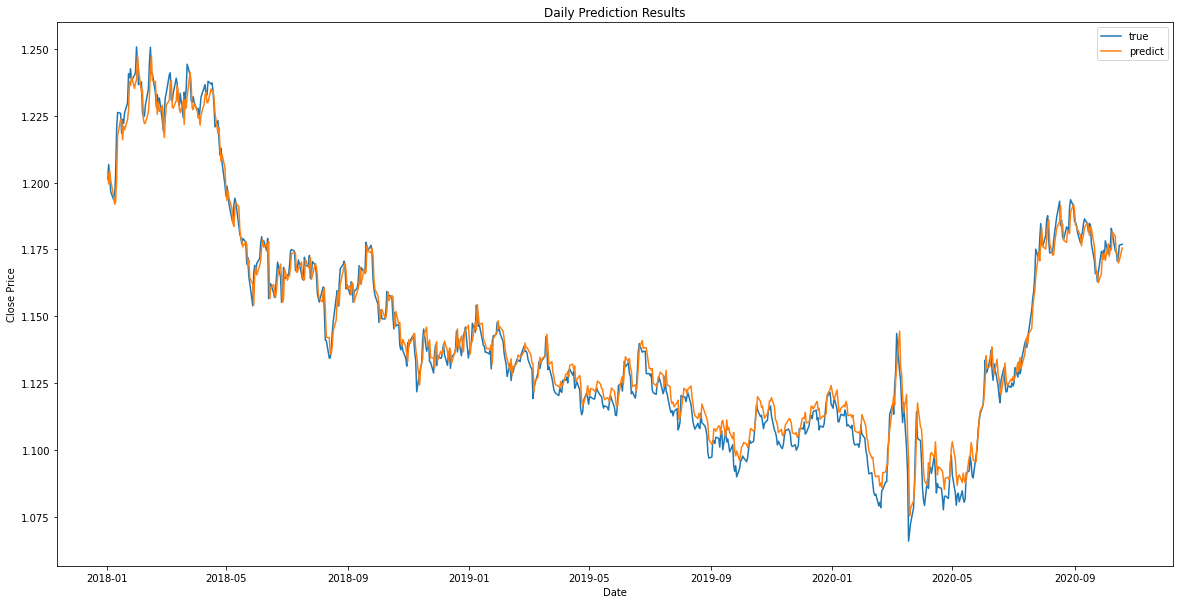

In [ ]:
#visualize data
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               #plot data
plt.figure(figsize=[20,10])
#plt.plot(trainyyy)
#plt.plot(testyyy)
plt.title('Daily Prediction Results')
plt.ylabel('Close Price')
plt.xlabel('Date')

plt.plot(dateDaily, trueTest_daily)
plt.plot(dateDaily, predictTest_daily)
plt.legend(['true', 'predict'], loc='upper right')
plt.show()

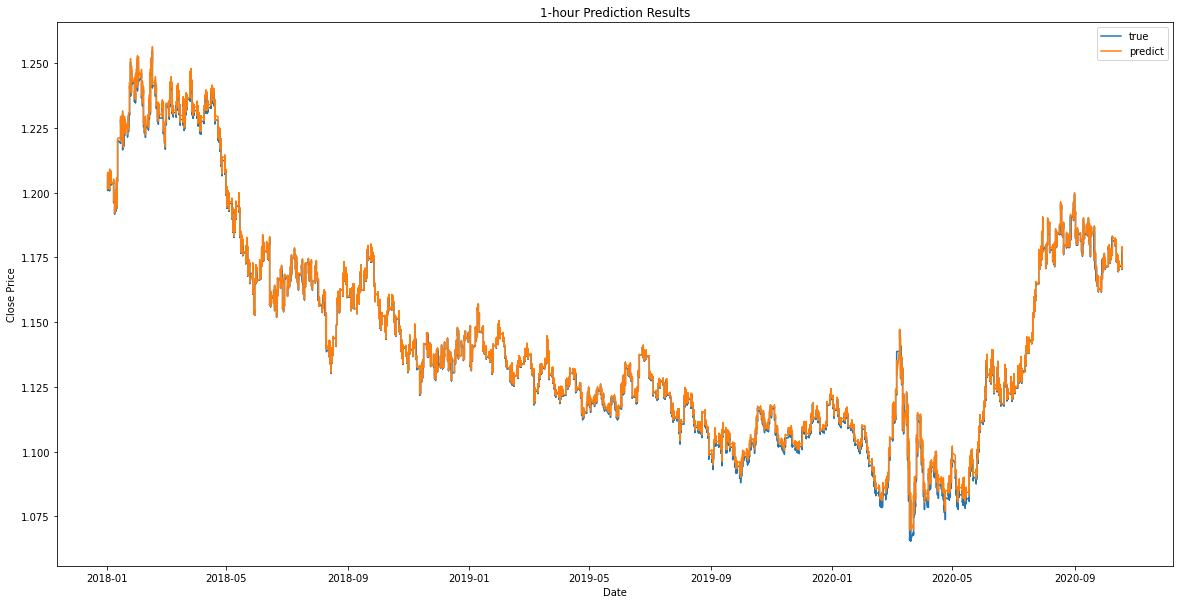

In [ ]:
#visualize data
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              #plot data
plt.figure(figsize=[20,10])
#plt.plot(trainyyy)
#plt.plot(testyyy)
plt.title('1-hour Prediction Results')
plt.ylabel('Close Price')
plt.xlabel('Date')

plt.plot(date_1H, trueTest_1H)
plt.plot(date_1H, predictTest_1H)
plt.legend(['true', 'predict'], loc='upper right')
plt.show()